## Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [4]:
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
#from torch.utils.data.dataset import Subset

In [5]:
import pandas as pd

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from tqdm.notebook import tqdm

In [8]:
import cv2
from google.colab.patches import cv2_imshow

In [9]:
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Dataset

### データの読み込み

In [10]:
def makeDataList(csv_path):
  datalist = pd.read_csv(csv_path)
  return datalist

In [11]:
datalist = makeDataList("/content/drive/MyDrive/ColabData/kaggle-digit-recognizer/train.csv")

In [12]:
datalist.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
train_datalist, test_datalist = train_test_split(datalist, test_size=0.1, random_state=1234, shuffle=True)

In [14]:
print(train_datalist.shape)
print(test_datalist.shape)
print(train_datalist.values)
train_datalist.head()

(37800, 785)
(4200, 785)
[[5 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]
 ...
 [9 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]]


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
10037,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13376,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13038,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3805,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3464,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Datasetの作成

In [15]:
#DataFrameからndarrayに変換.　Datasetを継承し，DataLoaderの第一引数にできる．
class DatasetMaker(Dataset):
  def __init__(self, datalist, transform=None):
    self.input_datalist = datalist.drop(["label"], axis=1).values.astype(np.float32).reshape(-1, 28, 28)
    self.label_datalist = datalist["label"].values.astype(np.int64)
    self.transform = transform

  def __len__(self):
    return len(self.input_datalist)

  def __getitem__(self, index):
    inputs = self.input_datalist[index]
    inputs = self.transform(inputs)
    labels = self.label_datalist[index]
    return inputs, labels

In [37]:
class AnsDatasetMaker(Dataset):
  def __init__(self, datalist, transform=None):
    self.input_datalist = datalist.values.astype(np.float32).reshape(-1, 28, 28)
    self.label_datalist = np.zeros(datalist.values.shape[0])
    print(datalist.values.shape[0])
    self.transform = transform

  def __len__(self):
    return len(self.input_datalist)

  def __getitem__(self, index):
    inputs = self.input_datalist[index]
    inputs = self.transform(inputs)
    labels = self.label_datalist[index]
    return inputs, labels

In [17]:
class ImageTransform():
  def __init__(self, mean=0, std=255):
    self.data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
  def __call__(self, img):
    return self.data_transform(img)

In [18]:
#デフォルトでは引数がindexではなくidxのため定義しなおしてみる．
class Subset(DatasetMaker):
    """
    Subset of a dataset at specified indices.

    Arguments:
        dataset (Dataset): The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
    """
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __getitem__(self, index):
        return self.dataset[self.indices[index]]

    def __len__(self):
        return len(self.indices)

In [19]:
trainval_dataset = DatasetMaker(train_datalist, transform=ImageTransform(mean=0, std=255))
n_samples = len(trainval_dataset)
train_size = int(n_samples * 0.8)

train_indices = list(range(0, train_size))
val_indices = list(range(train_size, n_samples))

train_dataset = Subset(trainval_dataset, train_indices)
val_dataset = Subset(trainval_dataset, val_indices)

test_dataset = DatasetMaker(test_datalist, transform=ImageTransform(mean=0, std=255))
print(train_dataset.__len__())
print(val_dataset.__len__())
#print(train_dataset.__getitem__(index=0)[0])
#print(train_dataset.__getitem__(index=0)[1])

30240
7560


torch.Size([1, 28, 28])
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000

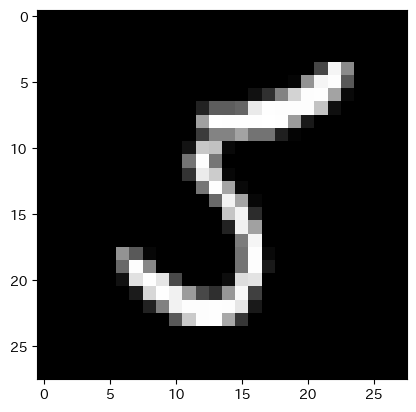

In [20]:
tmp = train_dataset.__getitem__(index=0)[0]
print(tmp.shape)
tmp = torch.squeeze(tmp)
print(tmp)
plt.imshow(tmp.detach().numpy().copy(), cmap="gray")
plt.show()

## DataLoader

In [21]:
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, drop_last=True)
dataloaders_dict = {"train":train_dataloader, "val":val_dataloader, "test":test_dataloader}
for inputs_tmp, labels_tmp in test_dataloader:
  break
#batch_itr = iter(dataloader)
#inputs, labels = next(batch_itr)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

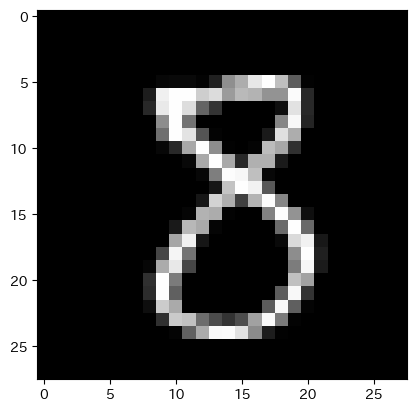

tensor([8, 3, 1,  ..., 8, 2, 1])
torch.Size([4200])


In [22]:
print(inputs_tmp)
print(inputs_tmp.size())
plt.imshow(inputs_tmp[0].detach().numpy().copy().reshape(28, 28), cmap="gray")
plt.show()
print(labels_tmp)
print(labels_tmp.size())

## Network

In [23]:
class net(nn.Module):
  def __init__(self, n_hidden, n_output):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, padding=(1, 1))
    self.conv2 = nn.Conv2d(32, 32, 3, padding=(1, 1))
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2, 2))
    self.flatten = nn.Flatten()
    # 1回のmaxpoolで14x14に．14*14*32=6272．
    self.l1 = nn.Linear(6272, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
      self.conv1,
      self.relu,
      self.conv2,
      self.relu,
      self.maxpool
    )

    self.classifier = nn.Sequential(
      self.l1,
      self.relu,
      self.l2
    )

  def forward(self, x):
    x = self.features(x)
    x = self.flatten(x)
    x = self.classifier(x)
    return x

In [24]:
n_input = len(train_dataset.__getitem__(index=0)[0])
n_hidden = 128
n_output = 10

In [25]:
net = net(n_hidden, n_output)

In [26]:
summary(net, (batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
net                                      [256, 10]                 --
├─Sequential: 1-1                        [256, 32, 14, 14]         9,248
│    └─Conv2d: 2-1                       [256, 32, 28, 28]         320
├─Sequential: 1-4                        --                        (recursive)
│    └─ReLU: 2-2                         [256, 32, 28, 28]         --
├─Sequential: 1-5                        --                        (recursive)
│    └─Conv2d: 2-3                       [256, 32, 28, 28]         9,248
├─Sequential: 1-4                        --                        (recursive)
│    └─ReLU: 2-4                         [256, 32, 28, 28]         --
├─Sequential: 1-5                        --                        (recursive)
│    └─MaxPool2d: 2-5                    [256, 32, 14, 14]         --
├─Flatten: 1-6                           [256, 6272]               --
├─Sequential: 1-7                        [

## Loss Function

In [27]:
criterion = nn.CrossEntropyLoss()

## Optimizer

In [28]:
#optimizer = optim.SGD(params=net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters())

## Train

In [29]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('------------')

    for phase in ["train", "val"]:
      if phase == "train":
        net.train()
      else:
        net.eval()

      epoch_loss = 0.0
      epoch_corrects = 0

      for inputs, labels in tqdm(dataloaders_dict[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=="train"):
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          _, preds = torch.max(outputs, dim=1)

          if phase == "train":
            loss.backward()
            optimizer.step()

          epoch_loss += loss.item() * inputs.size(0)
          epoch_corrects += torch.sum(preds ==labels)
      epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
      epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

## 学習ログ計算

In [30]:
num_epochs = 5
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs)

Epoch 1/5
------------


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.1887 Acc: 0.9249
Epoch 2/5
------------


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.0961 Acc: 0.9537
Epoch 3/5
------------


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.0723 Acc: 0.9598
Epoch 4/5
------------


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.0555 Acc: 0.9660
Epoch 5/5
------------


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.0624 Acc: 0.9638


In [31]:
save_weights_path = '/content/drive/MyDrive/Colab Notebooks/kaggle-digit-recognizer/digit-recognizer01/model.pth'
torch.save(net.state_dict(), save_weights_path)

## 評価

In [32]:
def Evaluator():
  for inputs, labels in dataloaders_dict["test"]:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, dim=1)

    corrects = torch.sum(preds == labels)
    print("acc:{}".format(corrects/len(dataloaders_dict["test"].dataset)))
    print("loss:{}".format(loss))

In [33]:
Evaluator()

acc:0.982619047164917
loss:0.061700060963630676


## 結果

In [39]:
ans_datalist = makeDataList("/content/drive/MyDrive/ColabData/kaggle-digit-recognizer/test.csv")
ans_datalist.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
ans_dataset = AnsDatasetMaker(ans_datalist, transform=ImageTransform(mean=0, std=255))
dataloaders_dict["ans"] = DataLoader(ans_dataset, batch_size=len(ans_dataset), shuffle=False, drop_last=True)

28000


In [42]:
for inputs, labels in dataloaders_dict["ans"]:
  break
print(inputs.shape)
print(labels)

torch.Size([28000, 1, 28, 28])
tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)


In [58]:
def Answer(net, dataloaders_dict, criterion, optimizer, num_epochs):
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('------------')

    for phase in ["ans"]:
      if phase == "train":
        net.train()
      else:
        net.eval()

      epoch_loss = 0.0
      epoch_corrects = 0

      for inputs, labels in tqdm(dataloaders_dict[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=="train"):
          outputs = net(inputs)
          _, preds = torch.max(outputs, dim=1)
  return preds

In [59]:
num_epochs = 1
preds = Answer(net, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs)

Epoch 1/1
------------


  0%|          | 0/1 [00:00<?, ?it/s]

In [61]:
print(preds)

tensor([2, 0, 9,  ..., 3, 9, 2], device='cuda:0')


In [75]:
submission = makeDataList("/content/drive/MyDrive/ColabData/kaggle-digit-recognizer/sample_submission.csv")
submission = submission.drop("Label", axis = 1)
submission.head()

,ImageId
0,1
1,2
2,3
3,4
4,5


In [76]:
preds_df = pd.DataFrame({"Label": preds.to("cpu").detach().numpy().copy()})
submission = pd.concat([submission, preds_df], axis=1)

In [77]:
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [78]:
save_csv_path = "/content/drive/MyDrive/Colab Notebooks/kaggle-digit-recognizer/digit-recognizer01/submission.csv"
submission.to_csv(save_csv_path, index=False)